# Module importation

In [1]:
import numpy as np
import cv2 as cv
import imutils
import os
import matplotlib.pyplot as plt

# Functions definitions

In [2]:
def variance_map(image, n):
    """ 
    Calculating variance for a given image, using an n-by-n kernel
    
      - param image: an image file loaded in python.
      - param n: size of kernel used to calculate the spatial variance of image \
      usually 3, 5 or 7.

    """

    kernel = np.ones((n,n), np.float32)/(n*n) #kernel definition
    image_mean = cv.filter2D(image/255, -1, kernel) #creating mean
    
    image_sqrmean = cv.filter2D((image/255)*(image/255), -1, kernel) #square
    image_var = (image_sqrmean - image_mean*image_mean)*255 #var = square - mean

    return image_var

def variance_map_mean(image, parameter_kernel):
    """
    Function taking an image and kernel sizes and returning mean of different\
    variance maps using different kernel sizes.

      - param image: an image file loaded in python.
      - param parameter_kernel: sizes of kernel, with possible values being \
      3, 5, 7, 35, 37, 57, 357

    """
    var3 = variance_map(image, 3) # creating variance map for kernel 3...
    var5 = variance_map(image, 5) # kernel 5...
    var7 = variance_map(image, 7) # kernel 7.

    if (parameter_kernel == 3):
        var_mean = var3
    elif (parameter_kernel == 5):
        var_mean = var5
    elif (parameter_kernel == 7):
        var_mean = var7
    elif (parameter_kernel == 35):
        var_mean = (var3 + var5)/2
    elif (parameter_kernel == 37):
        var_mean = (var3 + var7)/2
    elif (parameter_kernel == 57):
        var_mean = (var5 + var7)/2
    elif (parameter_kernel == 357):
        var_mean = (var3 + var5 + var7)/3
    else :
        print("The kernel parameter is wrong !")

    return  var_mean

def variance_map_modif(image_normale, image_var, seuil, alpha):
    """
    Modifying variance map in order the visualize correctly 

      - param image_normale: original image
      - param image_var: variance map created using variance_map
      - param seuil: intensity threshold to remove vessels
      - param alpha: small value used in order not to divide by zero
    """

    image_var2 = 1/(image_var + alpha)
    mat2 = np.array(image_var2)

    # normalization: ranging values between 0 and 1:
    image_var3 = image_var2 - mat2.min()/(mat2.max() - mat2.min())

    # ranging values between 0 and 255:
    image_var4 = image_var3*255
    image_var5 = image_var4.astype(np.uint8)

    # inverting image:
    image_var6 = 255 - image_var5
    
    # eliminating areas to intense in order to remove vessels: 
    image_var6[image_normale > seuil] = 255 
    
    return image_var6

def morph_iterative(image, n_kernel, n_iter):    
    """
    Performing morphology on image

      - param image: an image
      - param n_kernel: kernel size for morpholoy operation
      - param n_iter: number of iterations of morphology operation
    """

    # creating cross kernel
    kernel_cross = cv.getStructuringElement(cv.MORPH_CROSS,(n_kernel,n_kernel))

    # morphology operation = closing:
    close_image = cv.morphologyEx(image.astype(np.uint8), cv.MORPH_CLOSE, kernel_cross)

    # iteration of the morphology operation:
    image_temp = close_image
    if (n_iter == 0):
        return image_temp
    else:        
        for i in range(n_iter):
            image_temp = cv.GaussianBlur(image_temp, (5,5), 0)
            image_temp = cv.morphologyEx(image_temp.astype(np.uint8), cv.MORPH_CLOSE, kernel_cross)
            image_temp = cv.morphologyEx(image_temp.astype(np.uint8), cv.MORPH_OPEN, kernel_cross)

        return image_temp

def get_segmentation_map(
        image,
        intensity_threshold=75,
        variance_threshold=17,
        non_perfusion_threshold=250,
        number_of_morphology_iteration=1,
        kernel_size=35,
        alpha_variance=1):
    
    """
    Function taking an image and returning a binary segmentation map.

        - param image: an image file loaded in python, 2D array
        - param intensity_threshold: intensity threshold to remove vessels
        - param variance_threshold: variance threshold to keep non-perfusion predicted lesions
        - param non_perfusion_threshold: size threshold to remove small contours
        - param number_of_morphology_iteration: number of iterations of morphology operation
        - param kernel_size: size of kernel used to calculate the spatial variance of image
        - param alpha_variance: small value used in order not to divide by zero

    return: binary segmentation map
    """
    
    ### Normalizing image:
    norm_img = np.zeros((800,800))
    image = cv.normalize(image, norm_img, 0, 255, cv.NORM_MINMAX)

    ### Bilateral filtering:
    blur = cv.bilateralFilter(image, 9, 40, 40)

    ### Variance map:
    var_mean = variance_map_mean(blur, kernel_size)

    ### Variance map modification:
    image_var_finale = variance_map_modif(blur, var_mean, intensity_threshold, alpha_variance)

    ### Bilateral filtering:
    blur2 = cv.bilateralFilter(image_var_finale, 9, 40, 40)

    ### Morphylogy operation:
    morphed_image = morph_iterative(blur2, 5, number_of_morphology_iteration)

    ### Binarization using variance_threshold
    ret3, threshInv = cv.threshold(morphed_image, variance_threshold, 255, cv.THRESH_BINARY_INV)

    ### Non-perfusion predicted lesions contouring:
    cnts = cv.findContours(threshInv.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    ### Empty image to receive the selected contours:
    image_col = cv.cvtColor(np.zeros_like(image), cv.COLOR_GRAY2RGB)

    for (i, c) in enumerate(cnts):
        if (cv.contourArea(c) < non_perfusion_threshold): # removing small contours
            pass
        else :
            ((x, y), _) = cv.minEnclosingCircle(c)
            cv.drawContours(image_col, [c], -1, (255, 255, 255), thickness=cv.FILLED) 

    ### Keeping only on dimension (binary segmentation map):
    image_res = image_col[:, :, 0]

    return image_res

# Image segmentation

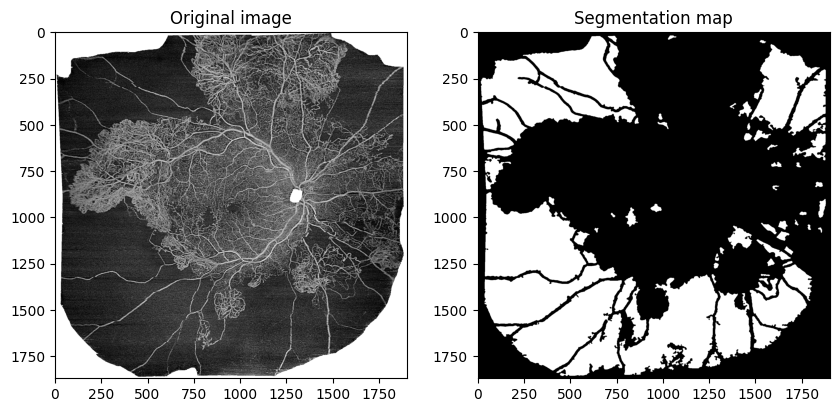

In [3]:
# loading image
image = cv.imread("octa_fullretina_exemple.bmp", 0)

# defining parameters
intensity_threshold = 75
variance_threshold = 17
non_perfusion_threshold = 250
number_of_morphology_iteration = 1
kernel_size = 35
alpha_variance = 1

# image segmentation
image_res = get_segmentation_map(
    image=image,
    intensity_threshold=intensity_threshold,
    variance_threshold=variance_threshold,
    non_perfusion_threshold=non_perfusion_threshold,
    number_of_morphology_iteration=number_of_morphology_iteration,
    kernel_size=kernel_size,
    alpha_variance=alpha_variance
)

# result visualisation
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.title("Original image")
plt.subplot(122)
plt.imshow(image_res, cmap="gray")
plt.title("Segmentation map")
plt.show()

